In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[0:92469] 
Y_train_SS = Y_train_SS[0:92469]
Y_train_V = Y_train_V[0:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 92469
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 92469 samples, validate on 13210 samples
Epoch 1/100
91712/92469 [============================>.] - ETA: 0s - loss: 0.0313 - dense_5_loss: 0.0221 - dense_6_loss: 0.0092 - dense_5_mse: 0.0221 - dense_6_mse: 0.0092

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01896, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 8s 85us/sample - loss: 0.0312 - dense_5_loss: 0.0220 - dense_6_loss: 0.0092 - dense_5_mse: 0.0220 - dense_6_mse: 0.0092 - val_loss: 0.0190 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0147 - val_dense_5_mse: 0.0043 - val_dense_6_mse: 0.0147
Epoch 2/100
92288/92469 [============================>.] - ETA: 0s - loss: 0.0121 - dense_5_loss: 0.0034 - dense_6_loss: 0.0087 - dense_5_mse: 0.0034 - dense_6_mse: 0.0087
Epoch 2: val_loss improved from 0.01896 to 0.01160, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 6s 68us/sample - loss: 0.0121 - dense_5_loss: 0.0034 - dense_6_loss: 0.0087 - dense_5_mse: 0.0034 - dense_6_mse: 0.0087 - val_loss: 0.0116 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0089 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0089
Epoch 3/100
92096/92469 [============================>.] - ETA: 0s - loss: 0.0087 - dense_5_loss: 0.0033 - dense_6_loss: 0.0054 - dense_5_mse: 0.0033 - dense_6_mse: 0.0054
Epoch 3: val_loss improved from 0.01160 to 0.01056, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 10s 107us/sample - loss: 0.0087 - dense_5_loss: 0.0033 - dense_6_loss: 0.0054 - dense_5_mse: 0.0033 - dense_6_mse: 0.0054 - val_loss: 0.0106 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0062 - val_dense_5_mse: 0.0043 - val_dense_6_mse: 0.0062
Epoch 4/100
92469/92469 [==============================] - ETA: 0s - loss: 0.0079 - dense_5_loss: 0.0032 - dense_6_loss: 0.0047 - dense_5_mse: 0.0032 - dense_6_mse: 0.0047
Epoch 4: val_loss did not improve from 0.01056
92469/92469 [==============================] - 8s 88us/sample - loss: 0.0079 - dense_5_loss: 0.0032 - dense_6_loss: 0.0047 - dense_5_mse: 0.0032 - dense_6_mse: 0.0047 - val_loss: 0.0132 - val_dense_5_loss: 0.0038 - val_dense_6_loss: 0.0094 - val_dense_5_mse: 0.0037 - val_dense_6_mse: 0.0094
Epoch 5/100
92128/92469 [============================>.] - ETA: 0s - loss: 0.0083 - dense_5_loss: 0.0032 - dense_6_loss: 0.0052 - dense_5_mse: 0.0032 - dense_6_mse: 0.0052
Epoch 5: val_loss impro

92469/92469 [==============================] - 8s 84us/sample - loss: 0.0083 - dense_5_loss: 0.0031 - dense_6_loss: 0.0052 - dense_5_mse: 0.0031 - dense_6_mse: 0.0052 - val_loss: 0.0048 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0034
Epoch 6/100
91808/92469 [============================>.] - ETA: 0s - loss: 0.0078 - dense_5_loss: 0.0030 - dense_6_loss: 0.0048 - dense_5_mse: 0.0030 - dense_6_mse: 0.0048
Epoch 6: val_loss improved from 0.00477 to 0.00405, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 7s 73us/sample - loss: 0.0078 - dense_5_loss: 0.0030 - dense_6_loss: 0.0047 - dense_5_mse: 0.0030 - dense_6_mse: 0.0047 - val_loss: 0.0041 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0025
Epoch 7/100
91872/92469 [============================>.] - ETA: 0s - loss: 0.0063 - dense_5_loss: 0.0026 - dense_6_loss: 0.0037 - dense_5_mse: 0.0026 - dense_6_mse: 0.0037
Epoch 7: val_loss did not improve from 0.00405
92469/92469 [==============================] - 5s 56us/sample - loss: 0.0063 - dense_5_loss: 0.0026 - dense_6_loss: 0.0037 - dense_5_mse: 0.0026 - dense_6_mse: 0.0037 - val_loss: 0.0058 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0034
Epoch 8/100
91936/92469 [============================>.] - ETA: 0s - loss: 0.0059 - dense_5_loss: 0.0024 - dense_6_loss: 0.0035 - dense_5_mse: 0.0024 - dense_6_mse: 0.0035
Epoch 8: val_loss did not

92469/92469 [==============================] - 8s 86us/sample - loss: 0.0054 - dense_5_loss: 0.0022 - dense_6_loss: 0.0033 - dense_5_mse: 0.0022 - dense_6_mse: 0.0033 - val_loss: 0.0033 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0019
Epoch 13/100
91968/92469 [============================>.] - ETA: 0s - loss: 0.0049 - dense_5_loss: 0.0019 - dense_6_loss: 0.0030 - dense_5_mse: 0.0019 - dense_6_mse: 0.0030
Epoch 13: val_loss did not improve from 0.00328
92469/92469 [==============================] - 5s 59us/sample - loss: 0.0049 - dense_5_loss: 0.0019 - dense_6_loss: 0.0030 - dense_5_mse: 0.0019 - dense_6_mse: 0.0030 - val_loss: 0.0038 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0025
Epoch 14/100
92064/92469 [============================>.] - ETA: 0s - loss: 0.0040 - dense_5_loss: 0.0016 - dense_6_loss: 0.0025 - dense_5_mse: 0.0016 - dense_6_mse: 0.0025
Epoch 14: val_loss did

92469/92469 [==============================] - 7s 71us/sample - loss: 0.0041 - dense_5_loss: 0.0017 - dense_6_loss: 0.0024 - dense_5_mse: 0.0017 - dense_6_mse: 0.0024 - val_loss: 0.0031 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0020
Epoch 16/100
92160/92469 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0023 - dense_5_mse: 0.0015 - dense_6_mse: 0.0023
Epoch 16: val_loss did not improve from 0.00308
92469/92469 [==============================] - 6s 63us/sample - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0023 - dense_5_mse: 0.0015 - dense_6_mse: 0.0023 - val_loss: 0.0038 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0027
Epoch 17/100
92384/92469 [============================>.] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022
Epoch 17: val_loss did

92469/92469 [==============================] - 6s 67us/sample - loss: 0.0030 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0026 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0016
Epoch 26/100
91744/92469 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019
Epoch 26: val_loss did not improve from 0.00265
92469/92469 [==============================] - 5s 57us/sample - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0044 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0024
Epoch 27/100
92469/92469 [==============================] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0012 - dense_6_loss: 0.0021 - dense_5_mse: 0.0012 - dense_6_mse: 0.0021
Epoch 27: val_loss did

92469/92469 [==============================] - 7s 78us/sample - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018 - val_loss: 0.0024 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0014
Epoch 33/100
92288/92469 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0010 - dense_6_loss: 0.0017 - dense_5_mse: 0.0010 - dense_6_mse: 0.0017
Epoch 33: val_loss improved from 0.00242 to 0.00233, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 7s 76us/sample - loss: 0.0027 - dense_5_loss: 0.0010 - dense_6_loss: 0.0017 - dense_5_mse: 0.0010 - dense_6_mse: 0.0017 - val_loss: 0.0023 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0012
Epoch 34/100
91744/92469 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 9.5659e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.5659e-04 - dense_6_mse: 0.0016
Epoch 34: val_loss did not improve from 0.00233
92469/92469 [==============================] - 6s 62us/sample - loss: 0.0026 - dense_5_loss: 9.5927e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.5930e-04 - dense_6_mse: 0.0016 - val_loss: 0.0027 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0015
Epoch 35/100
92320/92469 [============================>.] - ETA: 0s - loss: 0.0025 - dense_5_loss: 9.3067e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.3067e-04 - dense_6_mse: 0.001

92469/92469 [==============================] - 7s 75us/sample - loss: 0.0024 - dense_5_loss: 9.3834e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.3841e-04 - dense_6_mse: 0.0014 - val_loss: 0.0023 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0013
Epoch 40/100
92192/92469 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 8.9789e-04 - dense_6_loss: 0.0015 - dense_5_mse: 8.9789e-04 - dense_6_mse: 0.0015
Epoch 40: val_loss did not improve from 0.00233
92469/92469 [==============================] - 5s 56us/sample - loss: 0.0024 - dense_5_loss: 8.9712e-04 - dense_6_loss: 0.0015 - dense_5_mse: 8.9715e-04 - dense_6_mse: 0.0015 - val_loss: 0.0024 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0012
Epoch 41/100
91808/92469 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.001

92469/92469 [==============================] - 7s 76us/sample - loss: 0.0024 - dense_5_loss: 8.8761e-04 - dense_6_loss: 0.0015 - dense_5_mse: 8.8765e-04 - dense_6_mse: 0.0015 - val_loss: 0.0022 - val_dense_5_loss: 9.0799e-04 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 9.0791e-04 - val_dense_6_mse: 0.0013
Epoch 51/100
92192/92469 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 8.4453e-04 - dense_6_loss: 0.0014 - dense_5_mse: 8.4453e-04 - dense_6_mse: 0.0014
Epoch 51: val_loss did not improve from 0.00218
92469/92469 [==============================] - 6s 62us/sample - loss: 0.0023 - dense_5_loss: 8.4339e-04 - dense_6_loss: 0.0014 - dense_5_mse: 8.4345e-04 - dense_6_mse: 0.0014 - val_loss: 0.0028 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0015
Epoch 52/100
91648/92469 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 7.8869e-04 - dense_6_loss: 0.0013 - dense_5_mse: 7.8869e-04 - de

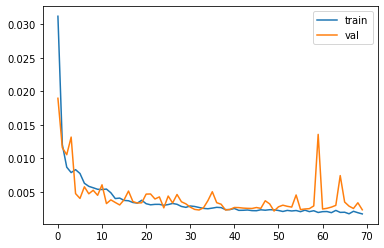

---Training time: 406.79854298 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98563, Train (V) - 0.93317
R2 scores: Validation (SS) - 0.97048, Validation (V) - 0.92193
R2 scores: Testing (SS) - 0.92871, Testing (V) - 0.85987
RMSE scores: Train (SS) - 0.01954, Train (V) - 0.02486
RMSE scores: Validation (SS) - 0.03232, Validation (V) - 0.03382
RMSE scores: Testing (SS) - 0.04922, Testing (V) - 0.04401


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

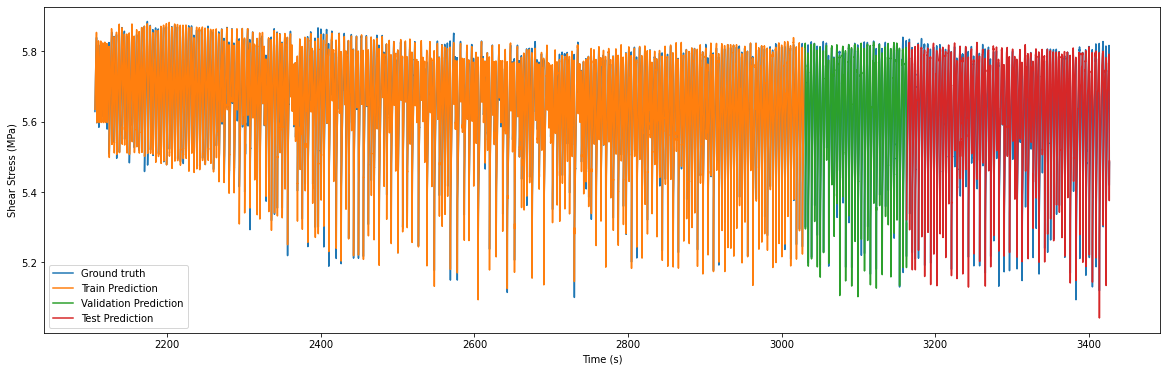

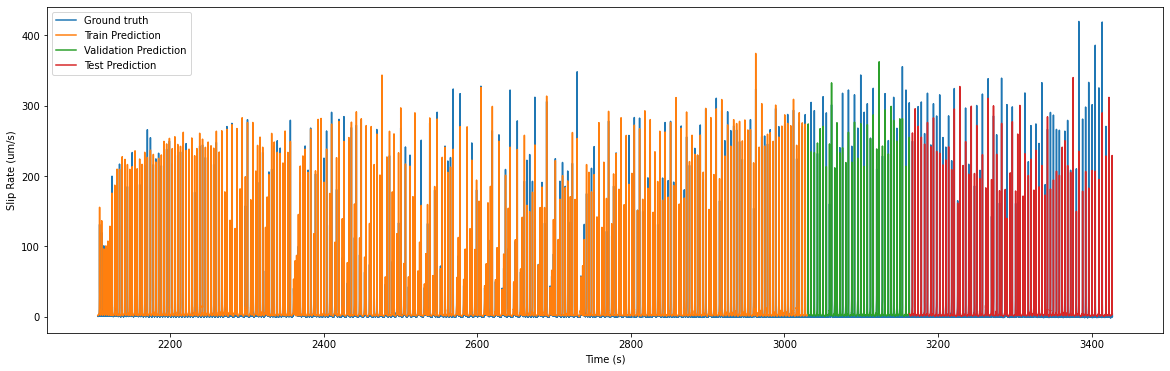

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

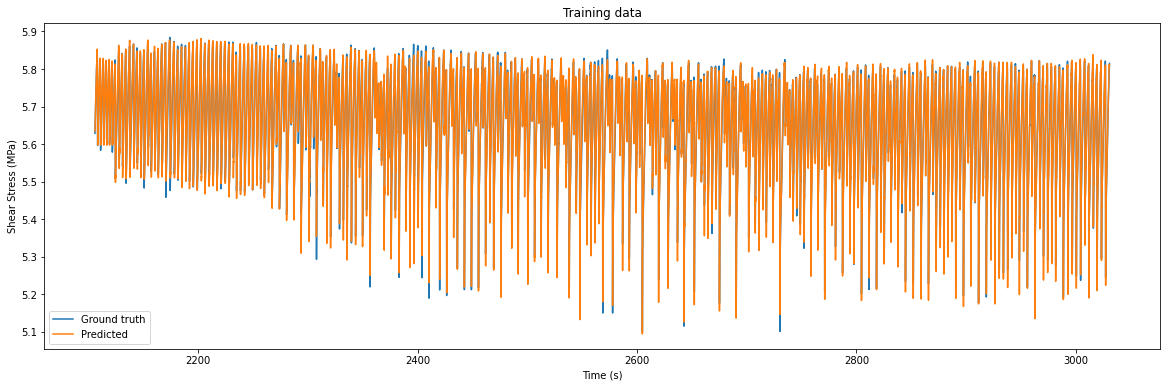

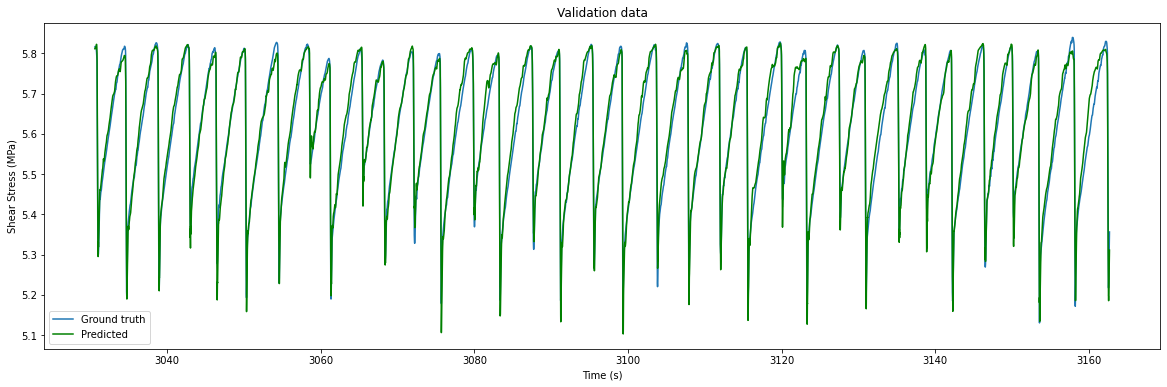

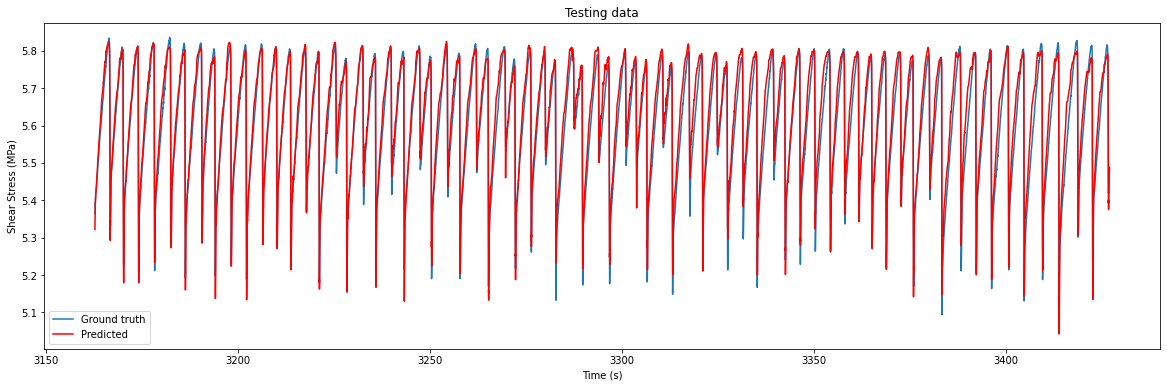

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

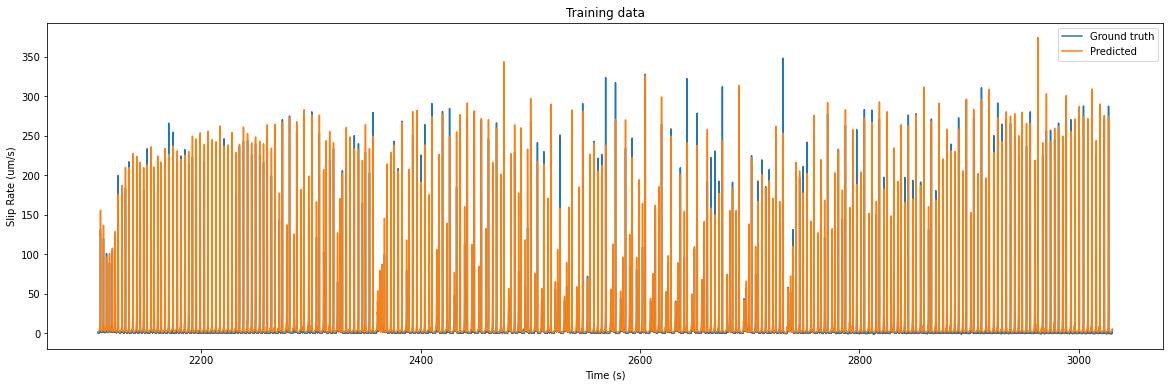

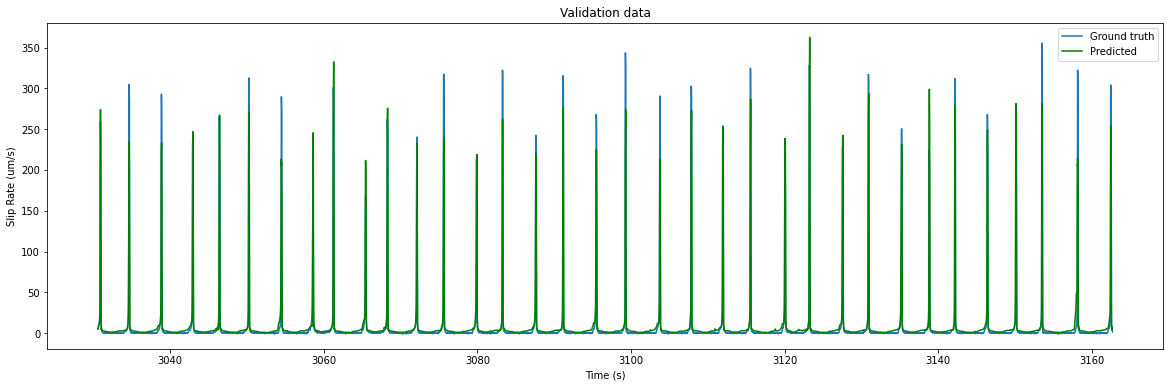

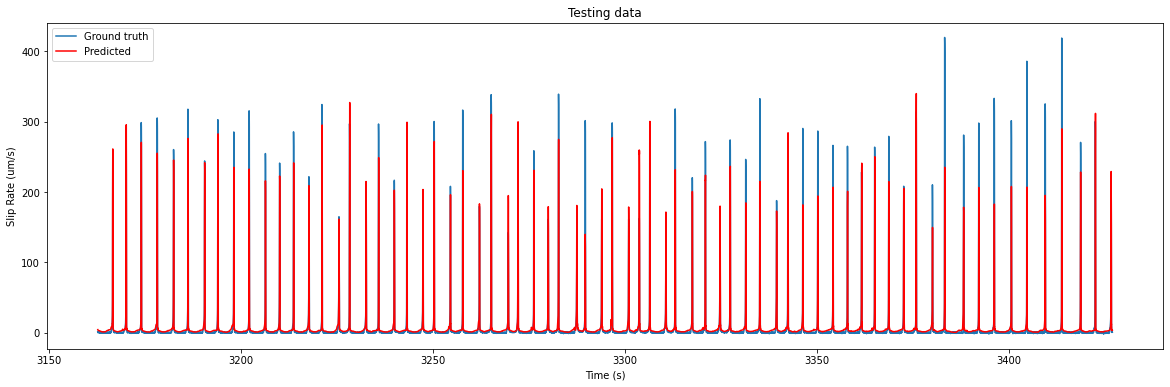

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')